In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data / Train-Test split
See model training notebooks for more information

In [4]:
BMMC = sp.read_h5ad("../GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
BMMC

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Load models / make predictions

In [5]:
models_folder = "../models/BMMC/"

models_data_types = {
    'ATAC': ["logreg_atac_model", "lsvm_atac_model", "lsvm_atac_model_balancedC", "RF_best_model_ATACseq"],
    "RNA": ["lsvm_gex_model"],
    "RNA_norm": ["LR_RNAseq_model", "RF_RNAseq_best_model", "SVM_RNAseq_model"],
    "Multiome": ["lsvm_multiome_model", "lsvm_multiome_model_balanced_C"],
    "Multiome_norm": ["lsvm_normalized_multiome_model", "lsvm_normalized_multiome_model_balanced_C"]
}
model_names = [x for xs in list(models_data_types.values()) for x in xs]
model_names_sanitizer_ = {
    'logreg_atac_model': "ATAC LogReg",
    'lsvm_atac_model': "ATAC lSVM",
    'lsvm_atac_model_balancedC': "ATAC lSVM Balanced",
    'RF_best_model_ATACseq': "ATAC RF",
    'lsvm_gex_model': "RNA lSVM",
    'LR_RNAseq_model': "Norm RNA LogReg",
    'RF_RNAseq_best_model': "Norm RNA RF",
    'SVM_RNAseq_model': "Norm RNA lSVM",
    'lsvm_multiome_model': "Multiome lSVM",
    'lsvm_multiome_model_balanced_C': "Multiome lSVM Balanced",
    'lsvm_normalized_multiome_model': "Norm Multiome lSVM",
    'lsvm_normalized_multiome_model_balanced_C': "Norm Multiome lSVM Balanced",
    'MLP_bmmc_pred': "ATAC MLP"
}
model_names_sanitizer = lambda x: np.vectorize(model_names_sanitizer_.get)(x)

model_names

['logreg_atac_model',
 'lsvm_atac_model',
 'lsvm_atac_model_balancedC',
 'RF_best_model_ATACseq',
 'lsvm_gex_model',
 'LR_RNAseq_model',
 'RF_RNAseq_best_model',
 'SVM_RNAseq_model',
 'lsvm_multiome_model',
 'lsvm_multiome_model_balanced_C',
 'lsvm_normalized_multiome_model',
 'lsvm_normalized_multiome_model_balanced_C']

In [6]:
models = {}
for m in model_names:
    with open(f"{models_folder}{m}.pkl", 'rb') as f:
        models[m] = pickle.load(f)

In [7]:
models

{'logreg_atac_model': LogisticRegression(C=0.001),
 'lsvm_atac_model': LinearSVC(C=0.0001),
 'lsvm_atac_model_balancedC': LinearSVC(C=3.1622776601683795e-05, class_weight='balanced'),
 'RF_best_model_ATACseq': RandomForestClassifier(min_samples_split=5),
 'lsvm_gex_model': LinearSVC(C=0.01),
 'LR_RNAseq_model': LogisticRegression(C=316.22776601683796),
 'RF_RNAseq_best_model': RandomForestClassifier(min_samples_leaf=3),
 'SVM_RNAseq_model': LinearSVC(C=1e-05),
 'lsvm_multiome_model': LinearSVC(C=0.01),
 'lsvm_multiome_model_balanced_C': LinearSVC(class_weight='balanced'),
 'lsvm_normalized_multiome_model': LinearSVC(C=0.03162277660168379),
 'lsvm_normalized_multiome_model_balanced_C': LinearSVC(C=0.001, class_weight='balanced')}

### Make predictions

In [8]:
donors = np.unique(BMMC.obs['DonorID'])
test_donors_idx = [19593, 28045, 28483]
test_filter = np.isin(BMMC.obs['DonorID'], test_donors_idx)
train_filter = np.invert(test_filter)

n_train = np.sum(train_filter)
n_test = np.sum(test_filter)

Y_test = BMMC.obs['cell_type'][test_filter]
Y_train = BMMC.obs['cell_type'][train_filter]
train_donors = BMMC.obs[train_filter]['DonorID']

In [9]:
from scipy.sparse import hstack, csc_matrix
from sklearn.preprocessing import StandardScaler

predictions_models_train = {}
predictions_models_test = {}
predictions_models_all = {}

for t, _models in models_data_types.items():
    print(f"Loading data type '{t}'")
    # Load correct data
    d = None
    if t == "ATAC":
        d = BMMC.obsm['ATAC_gene_activity']
    elif t == "RNA":
        d = BMMC.X
    elif t == "RNA_norm":
        scaler = StandardScaler(with_mean=False)
        d = scaler.fit_transform(BMMC.X)
    elif t == "Multiome":
        d = hstack((BMMC.X,BMMC.obsm['ATAC_gene_activity']))
        d = csc_matrix(d, dtype=np.float32)
    elif t == "Multiome_norm":
        scaler = StandardScaler(with_mean=False)
        d = hstack((scaler.fit_transform(BMMC.X),scaler.fit_transform(BMMC.obsm['ATAC_gene_activity'])))
        d = csc_matrix(d, dtype=np.float32)
    assert d is not None, f"Type {t} not found"
    
    X_test = d[test_filter]
    X_train = d[train_filter]
    
    for m in _models:
        print(f"Predicting model '{m}'")
        predictions_models_train[m] = models[m].predict(X_train)
        predictions_models_test[m] = models[m].predict(X_test)
        predictions_models_all[m] = models[m].predict(d)

del d # free mem
print("Done")

Loading data type 'ATAC'
Predicting model 'logreg_atac_model'
Predicting model 'lsvm_atac_model'
Predicting model 'lsvm_atac_model_balancedC'
Predicting model 'RF_best_model_ATACseq'
Loading data type 'RNA'
Predicting model 'lsvm_gex_model'
Loading data type 'RNA_norm'
Predicting model 'LR_RNAseq_model'
Predicting model 'RF_RNAseq_best_model'
Predicting model 'SVM_RNAseq_model'
Loading data type 'Multiome'
Predicting model 'lsvm_multiome_model'
Predicting model 'lsvm_multiome_model_balanced_C'
Loading data type 'Multiome_norm'
Predicting model 'lsvm_normalized_multiome_model'
Predicting model 'lsvm_normalized_multiome_model_balanced_C'
Done


In [10]:
# ADD MLP predictions
mlp_pred_file = "MLP_bmmc_pred"

with open(f"{models_folder}{mlp_pred_file}.pkl", 'rb') as f:
    tmp = pickle.load(f)
    predictions_models_test[mlp_pred_file] = tmp["test_pred_labels"]
    predictions_models_train[mlp_pred_file] = tmp["train_pred_labels"]
    predictions_models_all[mlp_pred_file] = tmp["full_pred_labels"]
    model_names.append(mlp_pred_file)

In [11]:
predictions_models_test

{'logreg_atac_model': array(['CD14+ Mono', 'Transitional B', 'CD8+ T', ..., 'CD8+ T', 'cDC2',
        'CD4+ T activated'], dtype=object),
 'lsvm_atac_model': array(['CD14+ Mono', 'Transitional B', 'CD8+ T', ..., 'CD8+ T', 'cDC2',
        'CD4+ T activated'], dtype=object),
 'lsvm_atac_model_balancedC': array(['CD14+ Mono', 'Transitional B', 'CD8+ T', ..., 'CD8+ T', 'cDC2',
        'CD4+ T naive'], dtype=object),
 'RF_best_model_ATACseq': array(['CD14+ Mono', 'Naive CD20+ B', 'CD8+ T', ..., 'CD8+ T',
        'CD14+ Mono', 'CD4+ T naive'], dtype=object),
 'lsvm_gex_model': array(['CD14+ Mono', 'Transitional B', 'CD8+ T', ..., 'CD8+ T', 'cDC2',
        'CD4+ T naive'], dtype=object),
 'LR_RNAseq_model': array(['CD14+ Mono', 'Transitional B', 'CD8+ T', ..., 'CD8+ T', 'cDC2',
        'CD4+ T naive'], dtype=object),
 'RF_RNAseq_best_model': array(['CD14+ Mono', 'Naive CD20+ B', 'NK', ..., 'CD8+ T', 'CD14+ Mono',
        'CD4+ T activated'], dtype=object),
 'SVM_RNAseq_model': array(['CD14+ M

## Main cell types

In [12]:
cell_types = np.unique(BMMC.obs['cell_type'])
main_cell_types = {
    'Monocytes': ['CD14+ Mono', 'CD16+ Mono'],
    'Plasmacytoid Dendritic Cells': ['pDC'],
    'Myeloid Dendritic Cells': ['cDC2'],
    'B Cells': ['Naive CD20+ B', 'Transitional B', 'B1 B', 'Plasma cell'],
    'NK Cells': ['NK'],
    'T Cells': ['CD8+ T', 'CD8+ T naive', 'CD4+ T naive', 'CD4+ T activated'],
    'Erythrocytes (RBCs), Eosinophils, and Neutrophils': ['Erythroblast', 'Normoblast', 'Proerythroblast'],
    'Hematopoietic Stem Cells and Progenitors': ['HSC', 'G/M prog', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog', 'MK/E prog']
}

main_cell_types_mapping = {x:k for k,v in main_cell_types.items() for x in v}

missing_cell_types = list(set(cell_types) - set(main_cell_types_mapping.keys()))
if len(missing_cell_types) > 0:
    missing_cell_types.sort()
    print(f"No main cell type for: {missing_cell_types}")
    for missing_cell_type in missing_cell_types:
        main_cell_types_mapping[missing_cell_type] = missing_cell_type

to_main_cell_types = lambda x: np.vectorize(main_cell_types_mapping.get)(x)

main_cell_types_sorted = sorted(list(main_cell_types.keys()) + missing_cell_types)
print(f"Main Cell Types: {main_cell_types_sorted}")

cell_types_sorted = np.concatenate((np.array([x for k,v in main_cell_types.items() for x in v]), np.array(missing_cell_types)))
print(f"All cell types: {cell_types_sorted}")

Main Cell Types: ['B Cells', 'Erythrocytes (RBCs), Eosinophils, and Neutrophils', 'Hematopoietic Stem Cells and Progenitors', 'Monocytes', 'Myeloid Dendritic Cells', 'NK Cells', 'Plasmacytoid Dendritic Cells', 'T Cells']
All cell types: ['CD14+ Mono' 'CD16+ Mono' 'pDC' 'cDC2' 'Naive CD20+ B' 'Transitional B'
 'B1 B' 'Plasma cell' 'NK' 'CD8+ T' 'CD8+ T naive' 'CD4+ T naive'
 'CD4+ T activated' 'Erythroblast' 'Normoblast' 'Proerythroblast' 'HSC'
 'G/M prog' 'ID2-hi myeloid prog' 'ILC' 'Lymph prog' 'MK/E prog']


In [13]:
Y_test_main = to_main_cell_types(Y_test)
Y_train_main = to_main_cell_types(Y_train)

# Models analysis

### Accuracy

In [14]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
[[n, accuracy_score(Y_test, p)] for n, p in predictions_models_test.items()]

[['logreg_atac_model', 0.8304973821989529],
 ['lsvm_atac_model', 0.8331697207678883],
 ['lsvm_atac_model_balancedC', 0.8393869982547993],
 ['RF_best_model_ATACseq', 0.662739965095986],
 ['lsvm_gex_model', 0.8233529668411868],
 ['LR_RNAseq_model', 0.8419502617801047],
 ['RF_RNAseq_best_model', 0.7444371727748691],
 ['SVM_RNAseq_model', 0.8451134380453752],
 ['lsvm_multiome_model', 0.8321880453752182],
 ['lsvm_multiome_model_balanced_C', 0.8318608202443281],
 ['lsvm_normalized_multiome_model', 0.8381871727748691],
 ['lsvm_normalized_multiome_model_balanced_C', 0.8385143979057592],
 ['MLP_bmmc_pred', 0.8462587260034904]]

In [15]:
models_in_plot = list(filter(lambda x: x[:2] != "RF", model_names)) # plot every model except RF
model_names_in_plot = model_names_sanitizer(models_in_plot)

# Sample data
p_test = [accuracy_score(Y_test, predictions_models_test[m]) for m in models_in_plot]
p_test_balanced = [balanced_accuracy_score(Y_test, predictions_models_test[m]) for m in models_in_plot]
p_test_main = [accuracy_score(Y_test_main, to_main_cell_types(predictions_models_test[m])) for m in models_in_plot]
p_train = [accuracy_score(Y_train, predictions_models_train[m]) for m in models_in_plot]

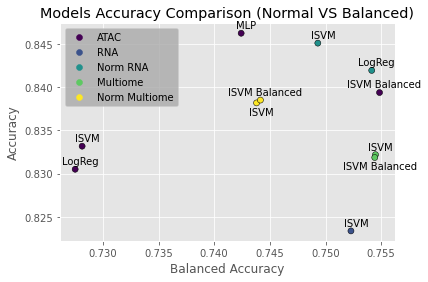

In [16]:
# Metrics to plot
x, y = p_test_balanced, p_test
x_label, y_label = "Balanced Accuracy", "Accuracy"

data_types = ['ATAC', 'RNA', 'Norm RNA', 'Multiome', 'Norm Multiome']

c = list(map(lambda a: [i for i,x in enumerate(data_types) if x in a][-1], model_names_in_plot))
model_names_in_plot_without_datatype = list(map(lambda a: " ".join(a.split(" ")[-2:]) if a.split(" ")[-1] == "Balanced" else a.split(" ")[-1], model_names_in_plot))
# Create scatter plot
s = plt.scatter(x, y, c=c, edgecolors="#000000")

# Add labels next to points
for label, c_, x_, y_ in zip(model_names_in_plot_without_datatype, c, x, y):
    vert_alignment = (5, -12 if c_ == 4 and label == "lSVM" or c_ == 3 and label == "lSVM Balanced" else 5)
    plt.annotate(label, (x_, y_), textcoords="offset points", xytext=vert_alignment, ha='center')

# Add title and labels
plt.title('Models Accuracy Comparison (Normal VS Balanced)')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(handles=s.legend_elements()[0], labels=data_types, facecolor="#aaaaaa")

# Show plot
plt.show()

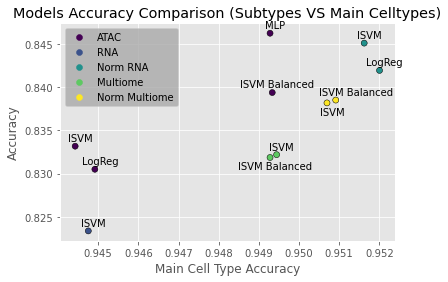

In [19]:
# Metrics to plot
x, y = p_test_main, p_test
x_label, y_label = "Main Cell Type Accuracy", "Accuracy"

data_types = ['ATAC', 'RNA', 'Norm RNA', 'Multiome', 'Norm Multiome']

c = list(map(lambda a: [i for i,x in enumerate(data_types) if x in a][-1], model_names_in_plot))
model_names_in_plot_without_datatype = list(map(lambda a: " ".join(a.split(" ")[-2:]) if a.split(" ")[-1] == "Balanced" else a.split(" ")[-1], model_names_in_plot))

# Create scatter plot
s = plt.scatter(x, y, c=c, edgecolors="#000000")

# Add labels next to points
for label, c_, x_, y_ in zip(model_names_in_plot_without_datatype, c, x, y):
    vert_alignment = (20 if c_ == 4 and label == "lSVM Balanced" else 5, -12 if c_ == 4 and label == "lSVM" or c_ == 3 and label == "lSVM Balanced" else 5)
    plt.annotate(label, (x_, y_), textcoords="offset points", xytext=vert_alignment, ha='center')

# Add title and labels
plt.title('Models Accuracy Comparison (Subtypes VS Main Celltypes)')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(handles=s.legend_elements()[0], labels=data_types, facecolor="#aaaaaa")

# Show plot
plt.show()

### Precision / Recall / F1 scores

In [20]:
from sklearn.metrics import f1_score, classification_report

for n, p in predictions_models_test.items():
    print(model_names_sanitizer(n))
    print(classification_report(Y_test, p))
#[[n, f1_score(Y_test, p)] for n, p in predictions_models_test.items()]

ATAC LogReg
                  precision    recall  f1-score   support

            B1 B       0.97      0.61      0.75       508
      CD14+ Mono       0.86      0.99      0.92      2269
      CD16+ Mono       0.95      0.82      0.88       370
CD4+ T activated       0.77      0.43      0.56      1167
    CD4+ T naive       0.32      0.75      0.45       463
          CD8+ T       0.91      0.96      0.93      5009
    CD8+ T naive       0.32      0.12      0.17       366
    Erythroblast       0.87      0.92      0.90       741
        G/M prog       0.79      0.23      0.35       617
             HSC       0.61      0.92      0.73       437
             ILC       0.55      0.05      0.09       129
      Lymph prog       0.94      0.68      0.79       573
       MK/E prog       0.71      0.77      0.74       293
              NK       0.89      0.91      0.90      1092
   Naive CD20+ B       0.78      0.99      0.87      1322
      Normoblast       0.94      0.87      0.90       237
 

/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

                  precision    recall  f1-score   support

            B1 B       0.89      0.18      0.30       508
      CD14+ Mono       0.49      1.00      0.65      2269
      CD16+ Mono       0.00      0.00      0.00       370
CD4+ T activated       0.63      0.32      0.43      1167
    CD4+ T naive       0.31      0.65      0.42       463
          CD8+ T       0.86      0.94      0.90      5009
    CD8+ T naive       0.00      0.00      0.00       366
    Erythroblast       0.52      0.87      0.65       741
        G/M prog       0.00      0.00      0.00       617
             HSC       0.56      0.05      0.10       437
             ILC       0.00      0.00      0.00       129
      Lymph prog       0.88      0.27      0.41       573
       MK/E prog       0.43      0.04      0.07       293
              NK       0.76      0.88      0.82      1092
   Naive CD20+ B       0.62      0.98      0.76      1322
      Normoblast       0.66      0.60      0.63       237
     Plasma c

/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

                  precision    recall  f1-score   support

            B1 B       0.94      0.09      0.16       508
      CD14+ Mono       0.76      0.99      0.86      2269
      CD16+ Mono       0.98      0.40      0.57       370
CD4+ T activated       0.67      0.35      0.46      1167
    CD4+ T naive       0.29      0.50      0.37       463
          CD8+ T       0.84      0.85      0.84      5009
    CD8+ T naive       0.00      0.00      0.00       366
    Erythroblast       0.82      0.87      0.84       741
        G/M prog       0.93      0.16      0.27       617
             HSC       0.62      0.93      0.74       437
             ILC       0.00      0.00      0.00       129
      Lymph prog       0.90      0.65      0.75       573
       MK/E prog       0.84      0.56      0.67       293
              NK       0.54      0.96      0.69      1092
   Naive CD20+ B       0.65      1.00      0.79      1322
      Normoblast       1.00      0.55      0.71       237
     Plasma c

                  precision    recall  f1-score   support

            B1 B       0.95      0.69      0.80       508
      CD14+ Mono       0.92      0.95      0.93      2269
      CD16+ Mono       0.82      0.92      0.87       370
CD4+ T activated       0.68      0.71      0.70      1167
    CD4+ T naive       0.39      0.46      0.42       463
          CD8+ T       0.91      0.95      0.93      5009
    CD8+ T naive       0.34      0.21      0.26       366
    Erythroblast       0.89      0.89      0.89       741
        G/M prog       0.70      0.46      0.55       617
             HSC       0.67      0.84      0.74       437
             ILC       0.67      0.09      0.16       129
      Lymph prog       0.93      0.75      0.83       573
       MK/E prog       0.77      0.72      0.74       293
              NK       0.89      0.90      0.90      1092
   Naive CD20+ B       0.81      0.98      0.89      1322
      Normoblast       0.98      0.81      0.89       237
     Plasma c

## Weights (Multiome models)

Multiome lSVM


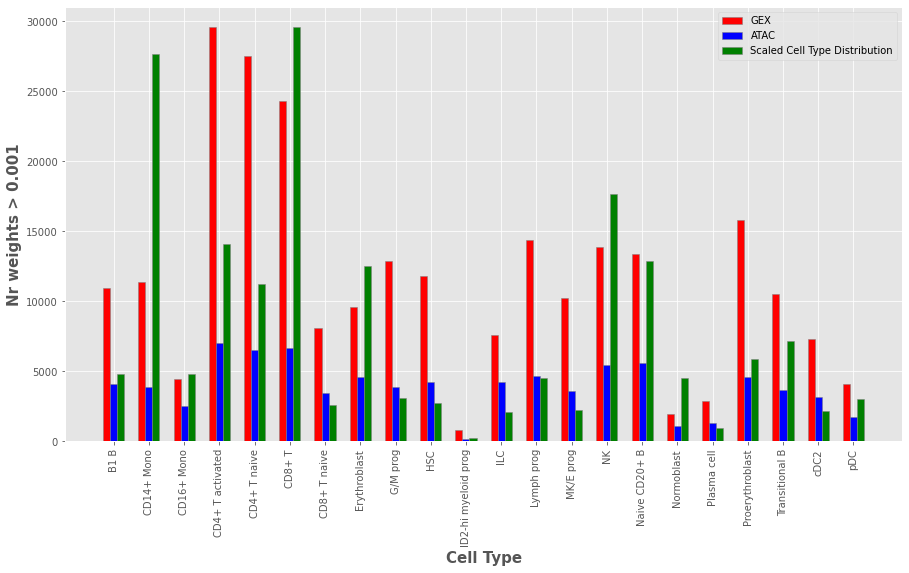

Multiome lSVM Balanced


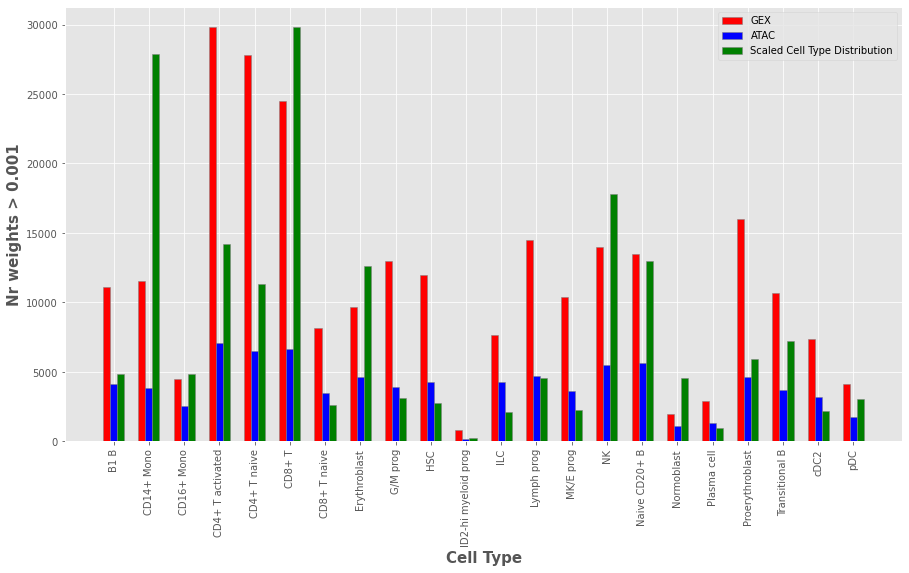

Norm Multiome lSVM


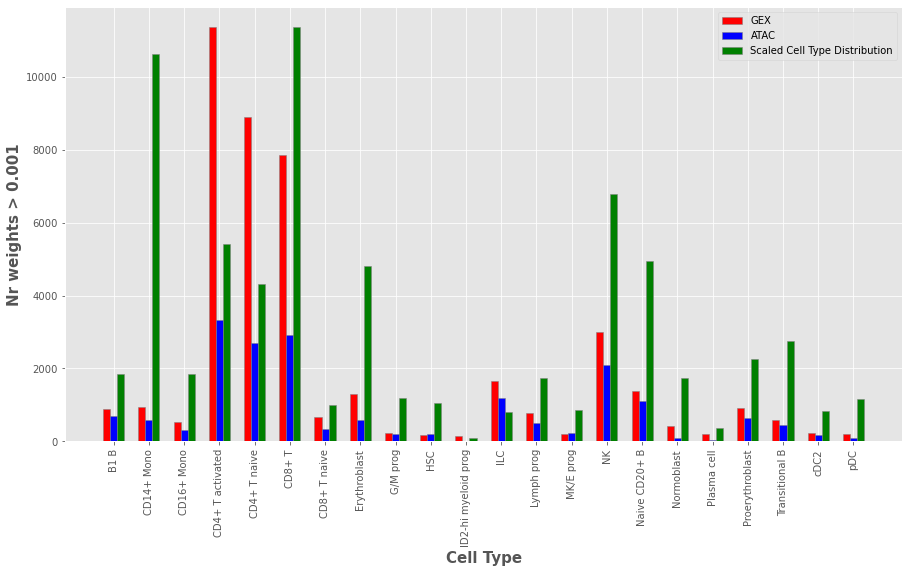

Norm Multiome lSVM Balanced


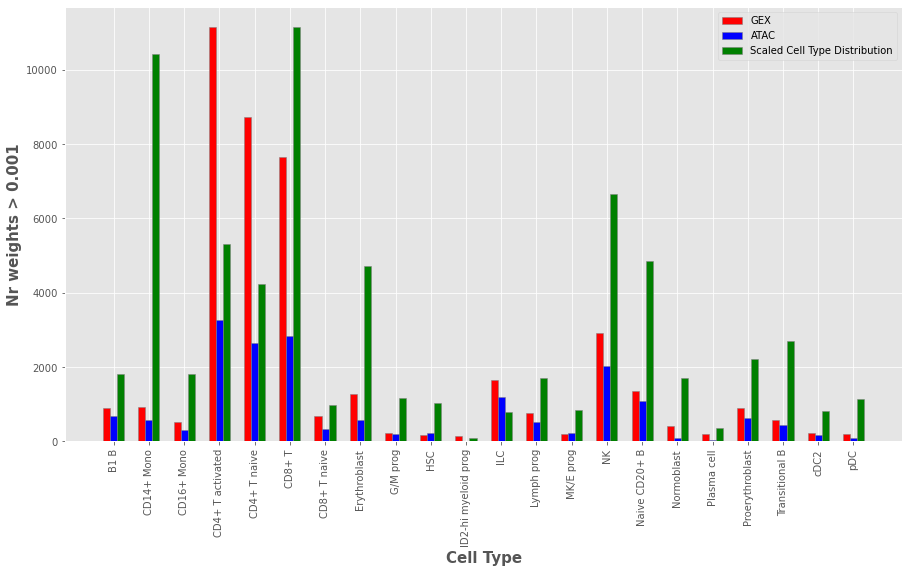

In [21]:
for n, m in list(models.items())[-4:]:
    print(model_names_sanitizer(n))
    
    # set width of bar 
    barWidth = 0.20
    fig = plt.subplots(figsize=(15, 8))

    # set heights of bars
    n_gex_samples = BMMC.X.shape[1]
    n_atac_samples = BMMC.obsm['ATAC_gene_activity'].shape[1]

    weight_cutoff = 1e-3
    idx = np.abs(m.coef_).argsort(axis=1)
    n_sign_gex_w = [np.logical_and(m.coef_[i,id] >= weight_cutoff, id < n_gex_samples).sum() for i, id in enumerate(idx)]
    n_sign_atac_w = [np.logical_and(m.coef_[i,id] >= weight_cutoff, id >= n_gex_samples).sum() for i, id in enumerate(idx)]

    # scale
    #n_sign_gex_w = n_sign_gex_w / n_gex_samples
    #n_sign_atac_w = n_sign_atac_w / n_atac_samples

    cell_types, cell_type_distr = np.unique(BMMC.obs['cell_type'], return_counts=True)
    cell_type_distr = cell_type_distr / cell_type_distr.max() * max(list(n_sign_gex_w) + list(n_sign_atac_w))

    # Set position of bar on X axis 
    br1 = np.arange(len(cell_types)) 
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    plt.bar(br1, n_sign_gex_w, color ='r', width = barWidth, 
            edgecolor ='grey', label ='GEX') 
    plt.bar(br2, n_sign_atac_w, color ='b', width = barWidth, 
            edgecolor ='grey', label ='ATAC')
    plt.bar(br3, cell_type_distr, color ='g', width = barWidth, 
            edgecolor ='grey', label ='Scaled Cell Type Distribution') 

    # Adding Xticks 
    plt.xlabel('Cell Type', fontweight ='bold', fontsize = 15) 
    plt.ylabel(f'Nr weights > {weight_cutoff}', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r, _ in enumerate(cell_types)], cell_types, rotation=90)

    plt.legend(loc='upper right')
    plt.show() 

Multiome lSVM


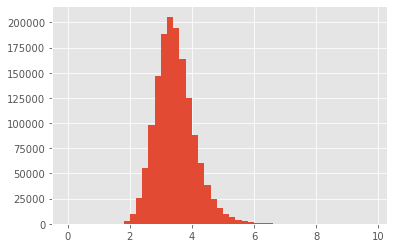

Multiome lSVM Balanced


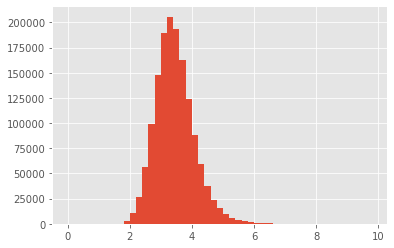

Norm Multiome lSVM


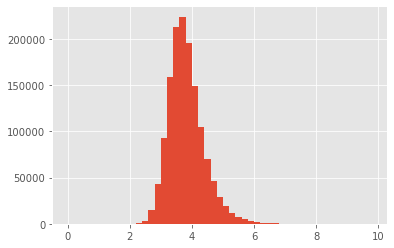

Norm Multiome lSVM Balanced


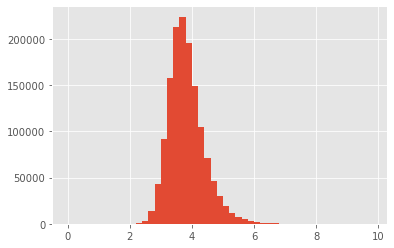

In [32]:
for n, m in list(models.items())[-4:]:
    print(model_names_sanitizer(n))
    coef = m.coef_.flatten()
    coef = np.where(coef > 0.0000000001, coef, -10)
    np.log10(coef, out=coef, where=coef > 0)
    plt.hist(coef * -1, bins=np.arange(0, 10, 0.2))
    plt.show()

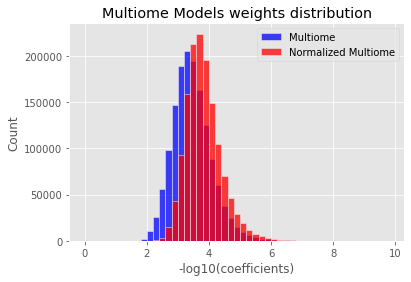

In [46]:
from seaborn import histplot

for m, c in ('lsvm_multiome_model', 'blue'), ('lsvm_normalized_multiome_model', 'red'):
    coef = models[m].coef_.flatten()
    coef = np.where(coef > 0.0000000001, coef, -10)
    np.log10(coef, out=coef, where=coef > 0)
    histplot(coef * -1, bins=np.arange(0, 10, 0.2), color=c)
plt.legend(('Multiome', 'Normalized Multiome'))
plt.title('Multiome Models weights distribution')
plt.xlabel("-log10(coefficients)")
plt.show()

### Umaps

In [137]:
umap_coordinates_train = BMMC.obsm['ATAC_umap'][train_filter]
umap_coordinates_test = BMMC.obsm['ATAC_umap'][test_filter]

plt.rcParams['figure.figsize'] = [20, 20]
    
def show_models_predictions(_umapcoords, _model_predictions, _labels, _celltypes, _maincelltypes=False, title='Umap Model Predictions', s=5):
    
    pred_by_nr_of_models = np.sum(np.array([to_main_cell_types(x) == Y_test_main if _maincelltypes else x == Y_test for x in _model_predictions.values()]), axis=0)
    
    cm = plt.cm.coolwarm(np.linspace(0,1,len(_model_predictions) + 1))
    
    for i, c in enumerate(cm):
        plt.scatter(_umapcoords[pred_by_nr_of_models == i, 0], _umapcoords[pred_by_nr_of_models == i, 1], label=i, color=c, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title, fontsize=15)
    plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=len(_model_predictions), clip=False), cmap=plt.cm.coolwarm))
    plt.show()
    

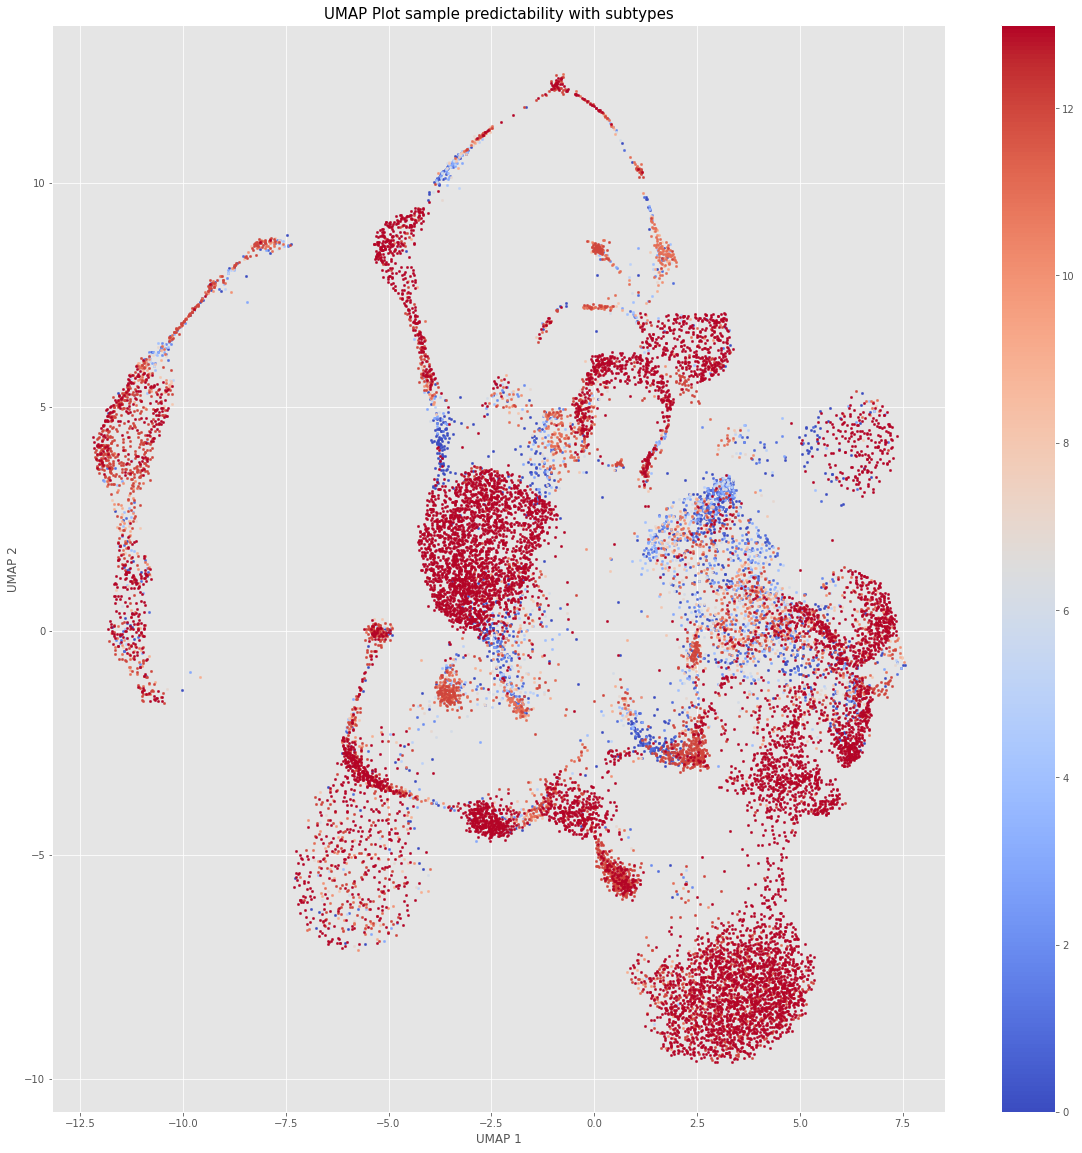

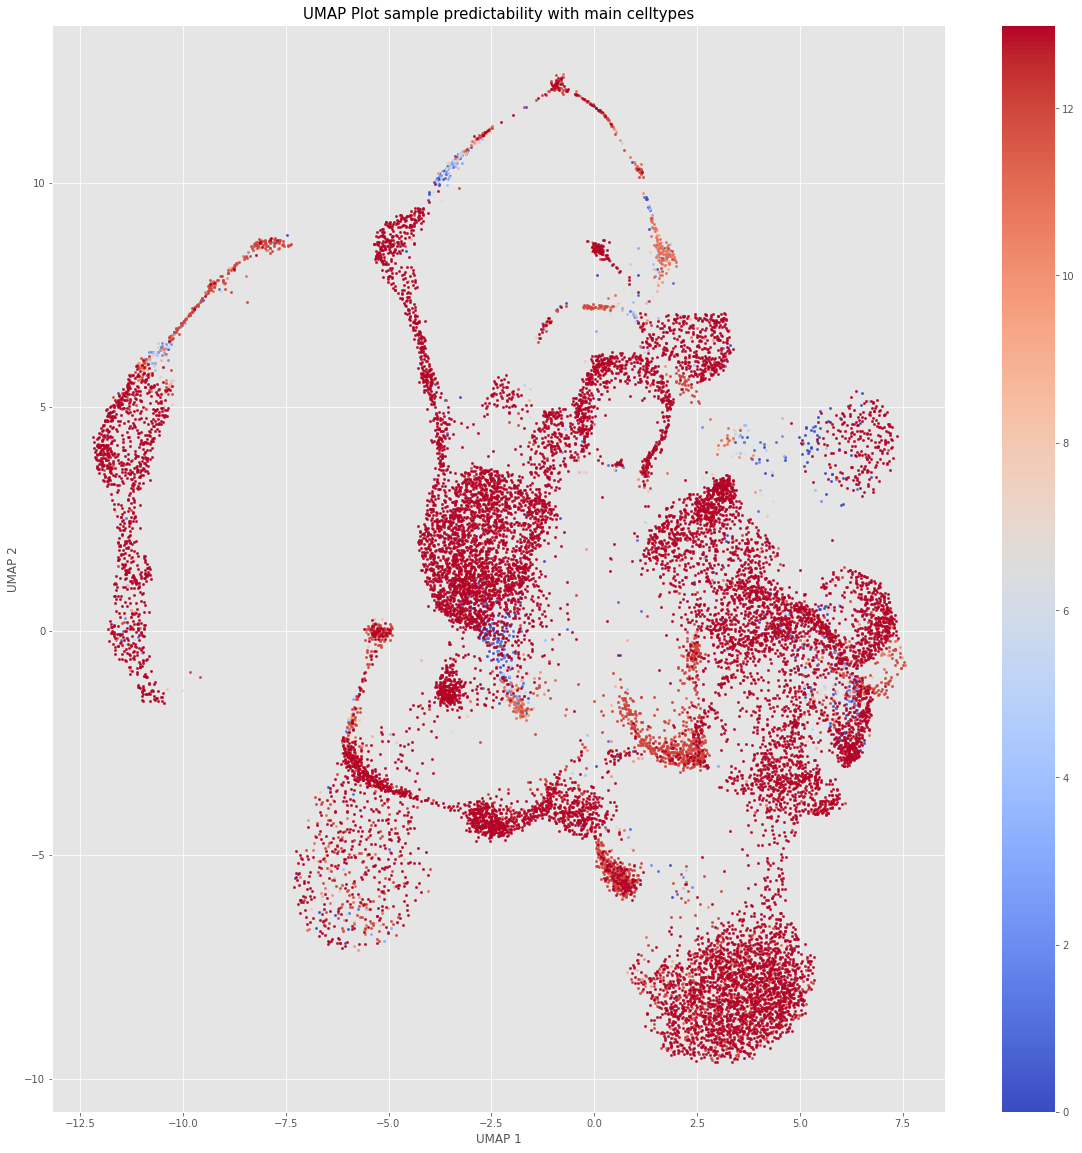

In [138]:
show_models_predictions(umap_coordinates_test, predictions_models_test, Y_test, cell_types_sorted, _maincelltypes=False, title='UMAP Plot sample predictability with subtypes')
show_models_predictions(umap_coordinates_test, predictions_models_test, Y_test, cell_types_sorted, _maincelltypes=True, title='UMAP Plot sample predictability with main celltypes')